In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats

%matplotlib inline
from matplotlib import font_manager, rc

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from pathlib import Path

def load_xml_glucose(path: str) -> pd.DataFrame:
    root = ET.parse(path).getroot()
    pid = str(root.attrib.get("id", Path(path).stem.split("-")[0]))
    rows = []
    for ev in root.find("glucose_level").findall("event"):
        ts = ev.attrib["ts"]
        try:
            ds = pd.to_datetime(ts, format="%d-%m-%Y %H:%M:%S", errors="raise")
        except Exception:
            ds = pd.to_datetime(ts, errors="coerce")  
        rows.append({"patient_id": pid, "ds": ds, "y": float(ev.attrib["value"])})
    df = (pd.DataFrame(rows)
            .dropna(subset=["ds"])
            .sort_values("ds")
            .reset_index(drop=True))
    df["y"] = df["y"].astype("float32")
    return df


In [11]:
dis_570 = load_xml_glucose("570-ws-training.xml")
dis_570["group"] = "유병자"


dis_588 = load_xml_glucose("588-ws-training.xml")
dis_588["group"] = "유병자"

dis_563 = load_xml_glucose("563-ws-training.xml")
dis_563["group"] = "유병자_563"


norm = load_xml_glucose("normal_glucose.xml")
norm["group"] = "정상"


df_all = pd.concat([dis_570, dis_588, norm], ignore_index=True)

print(len(dis_570), len(dis_588), len(norm))
print(df_all.groupby("group").size())

df_all.head(5)


10982 12640 17280
group
유병자    23622
정상     17280
dtype: int64


,patient_id,ds,y,group
0,570,2021-12-07 16:29:00,101.0,유병자
1,570,2021-12-07 16:34:00,100.0,유병자
2,570,2021-12-07 16:39:00,100.0,유병자
3,570,2021-12-07 16:44:00,99.0,유병자
4,570,2021-12-07 16:49:00,98.0,유병자


In [13]:
min_len = min(len(dis_570), len(dis_588), len(norm))

dis_570 = dis_570.iloc[:min_len].reset_index(drop=True)
dis_588 = dis_588.iloc[:min_len].reset_index(drop=True)
dis_563 = dis_588.iloc[:min_len].reset_index(drop=True)
norm    = norm.iloc[:min_len].reset_index(drop=True)

In [7]:
print(dis_570.columns)
print(dis_570.head(3))


Index(['patient_id', 'ds', 'y', 'group'], dtype='object')
  patient_id                  ds      y group
0        570 2021-12-07 16:29:00  101.0   유병자
1        570 2021-12-07 16:34:00  100.0   유병자
2        570 2021-12-07 16:39:00  100.0   유병자


In [14]:
rows = []
for label, df in [("유병자_570", dis_570), ("유병자_588", dis_588), ("유병자_563", dis_563), ("정상", norm)]:
    s = df["y"]   
    for H in (30, 60, 120):
        res = baseline_mae_strict(s, H, ma_windows=(3,12))
        row = {"group": label, **{k: round(v,2) for k,v in res.items()}}
        rows.append(row)

mae_tbl_multi = pd.DataFrame(rows)
print(mae_tbl_multi)

mae_tbl_mean = mae_tbl_multi.groupby("group").mean(numeric_only=True)
print(mae_tbl_mean)


      group  naive@30m  MA3@30m  MA12@30m  naive@60m  MA3@60m  MA12@60m  \
0   유병자_570      14.38    17.54     22.98        NaN      NaN       NaN   
1   유병자_570        NaN      NaN       NaN  23.490000    25.99     30.56   
2   유병자_570        NaN      NaN       NaN        NaN      NaN       NaN   
3   유병자_588      17.77    21.23     26.15        NaN      NaN       NaN   
4   유병자_588        NaN      NaN       NaN  27.559999    29.78     32.83   
5   유병자_588        NaN      NaN       NaN        NaN      NaN       NaN   
6   유병자_563      17.77    21.23     26.15        NaN      NaN       NaN   
7   유병자_563        NaN      NaN       NaN  27.559999    29.78     32.83   
8   유병자_563        NaN      NaN       NaN        NaN      NaN       NaN   
9        정상       9.71     9.82     11.34        NaN      NaN       NaN   
10       정상        NaN      NaN       NaN  12.620000    12.81     14.21   
11       정상        NaN      NaN       NaN        NaN      NaN       NaN   

    naive@120m  MA3@120m

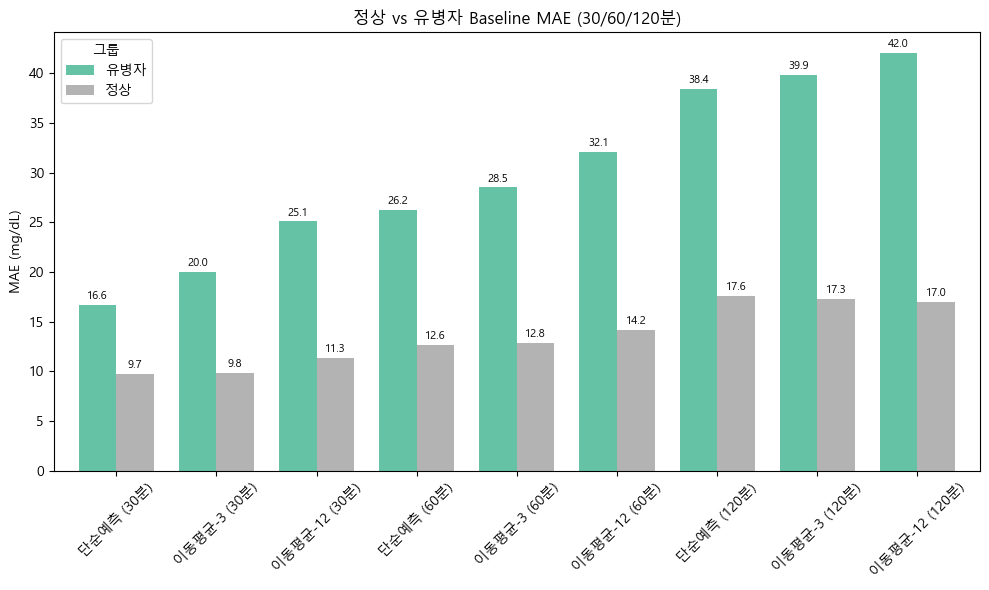

In [17]:

label_map = {
    "naive@30m": "단순예측 (30분)",
    "MA3@30m": "이동평균-3 (30분)",
    "MA12@30m": "이동평균-12 (30분)",
    "naive@60m": "단순예측 (60분)",
    "MA3@60m": "이동평균-3 (60분)",
    "MA12@60m": "이동평균-12 (60분)",
    "naive@120m": "단순예측 (120분)",
    "MA3@120m": "이동평균-3 (120분)",
    "MA12@120m": "이동평균-12 (120분)"
}


mae_compare_mean.rename(index=label_map, inplace=True)


mae_compare_mean.rename(columns={
    "유병자 평균": "유병자",
    "정상": "정상"
}, inplace=True)

ax = mae_compare_mean.plot(
    kind="bar", figsize=(10,6), width=0.75, colormap="Set2"
)

plt.ylabel("MAE (mg/dL)")
plt.title("정상 vs 유병자 Baseline MAE (30/60/120분)")
plt.xticks(rotation=45)


for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}",
                (p.get_x() + p.get_width()/2., p.get_height()+0.3),
                ha="center", va="bottom", fontsize=8)

plt.legend(title="그룹", loc="upper left")
plt.tight_layout()
plt.show()
